# Load data

In [1]:
import json
import torch
# Load the dataset
with open("clinc150_uci/data_full.json", "r") as file:
    data = json.load(file)


In [2]:
# Extracting data
train_data = data['train']
val_data = data['val']
test_data = data['test']

oos_train_data = data['oos_train']
oos_val_data = data['oos_val']
oos_test_data = data['oos_test']

# Get sentences and labels
train_sentences = [item[0] for item in train_data]
train_labels = [item[1] for item in train_data]

val_sentences = [item[0] for item in val_data]
val_labels = [item[1] for item in val_data]

test_sentences = [item[0] for item in test_data]
test_labels = [item[1] for item in test_data]

oos_train_sentences = [item[0] for item in oos_train_data]
oos_val_sentences = [item[0] for item in oos_val_data]
oos_test_sentences = [item[0] for item in oos_test_data]

# Check the number of samples in each subset
len(train_sentences), len(val_sentences), len(test_sentences), len(oos_train_sentences), len(oos_val_sentences), len(oos_test_sentences)


(15000, 3000, 4500, 100, 100, 1000)

In [3]:
unique_intents = list(set(train_labels)) 
unique_intents[:5]

['application_status', 'change_language', 'goodbye', 'todo_list', 'recipe']

In [4]:
from sentence_transformers import SentenceTransformer, models

In [5]:
word_embedding_model = models.Transformer('distilroberta-base')

In [6]:
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),pooling_mode="max")

In [7]:
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [8]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': True, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [9]:
train_embeddings = model.encode(train_sentences)
val_embeddings = model.encode(val_sentences)
test_embeddings = model.encode(test_sentences)
oos_train_embeddings = model.encode(oos_train_sentences)
oos_val_embeddings = model.encode(oos_val_sentences)
oos_test_embeddings = model.encode(oos_test_sentences)

In [95]:
train_embeddings = encode_sentences(train_sentences, model_path, tokenizer_path)
val_embeddings = encode_sentences(val_sentences, model_path, tokenizer_path)
test_embeddings = encode_sentences(test_sentences, model_path, tokenizer_path)
oos_train_embeddings = encode_sentences(oos_train_sentences, model_path, tokenizer_path)
oos_val_embeddings = encode_sentences(oos_val_sentences, model_path, tokenizer_path)
oos_test_embeddings = encode_sentences(oos_test_sentences, model_path, tokenizer_path)

In [96]:
train_embeddings.shape

(15000, 768)

In [97]:
import numpy as np
from scipy.linalg import inv

In [98]:
intent_means = {}

for intent in unique_intents:
    indices = [i for i, label in enumerate(train_labels) if label == intent]
    intent_embeddings = train_embeddings[indices]
    intent_mean = np.mean(intent_embeddings, axis=0)
    intent_means[intent] = intent_mean

In [99]:
len(intent_means)

150

In [100]:
intent_means["damaged_card"].shape

(768,)

In [101]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

In [102]:
covariance = np.cov(train_embeddings, rowvar=False)
cov_inverse = inv(covariance)

In [103]:
from scipy.spatial import distance

In [104]:
# Function to get the minimum Mahalanobis distance to any intent for a given sample
def min_mahalanobis_for_sample(sample, intent_means, cov_inverse):
    distances = [distance.mahalanobis(sample, mean, cov_inverse) for mean in intent_means.values()]
    return min(distances)


In [105]:
from sklearn.metrics import average_precision_score

# Compute minimum Mahalanobis distances for samples in test_embeddings and oos_test_embeddings
test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in test_embeddings]
oos_test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in oos_test_embeddings]

# True binary labels: 0 for in-domain and 1 for OOD
y_true = [0] * len(test_scores) + [1] * len(oos_test_scores)

# Combine the scores
y_scores = test_scores + oos_test_scores

# Compute AUPR
aupr = average_precision_score(y_true, y_scores)
aupr


0.8489098704934985

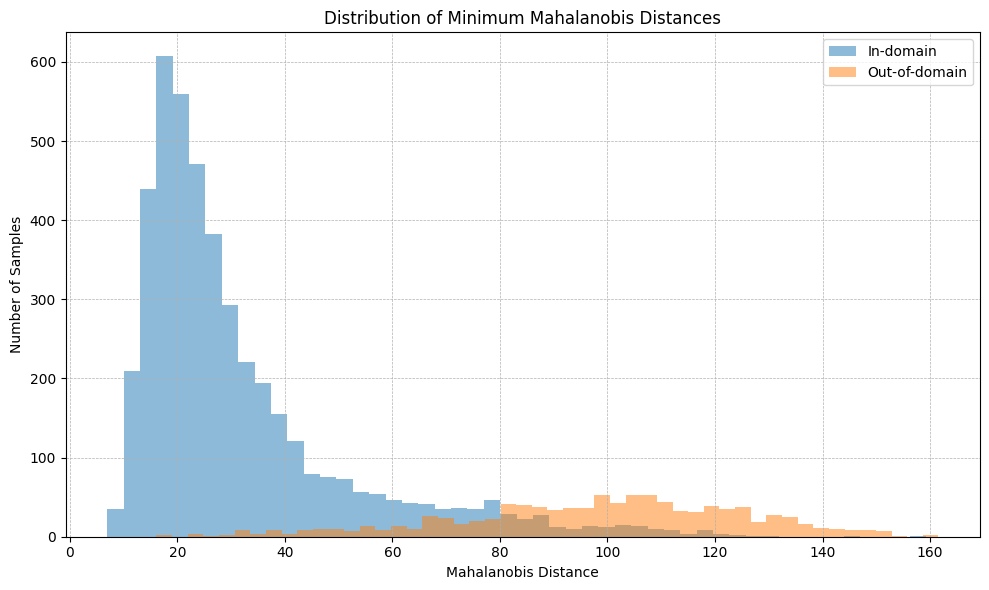

In [106]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_scores, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_scores, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Minimum Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


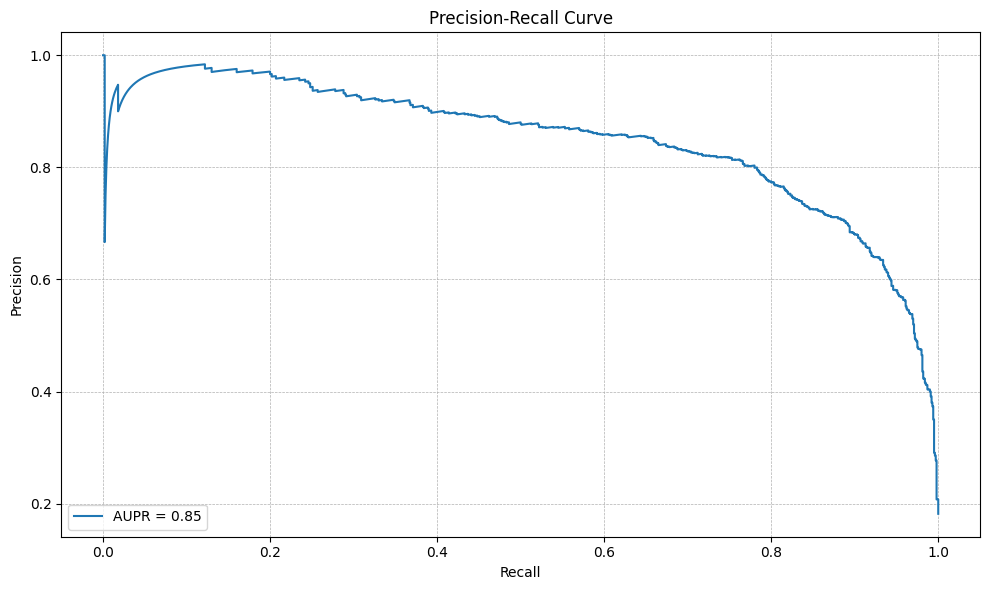

In [107]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Calculate the area under the precision-recall curve
aupr = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AUPR = {aupr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [108]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Find the FPR where the TPR is closest to 0.95
idx = np.where(tpr >= 0.95)[0][0]
fpr_95 = fpr[idx]

fpr_95

0.15244444444444444

# KNN, K=1

In [287]:
from sklearn.neighbors import NearestNeighbors

# Initialize and fit the Nearest Neighbors model (with k=1)
knn = NearestNeighbors(n_neighbors=1)
knn.fit(train_embeddings)

NearestNeighbors(n_neighbors=1)

In [288]:
train_embeddings.shape

(15000, 768)

In [289]:
# Compute the distances to the nearest neighbors for the in-domain test set
distances_in, _ = knn.kneighbors(test_embeddings)
# Compute the distances to the nearest neighbors for the OOD test set
distances_out, _ = knn.kneighbors(oos_test_embeddings)

In [290]:
scores_in = distances_in.squeeze()
scores_out = distances_out.squeeze()

In [291]:
y_scores_knn = np.concatenate([scores_in, scores_out])

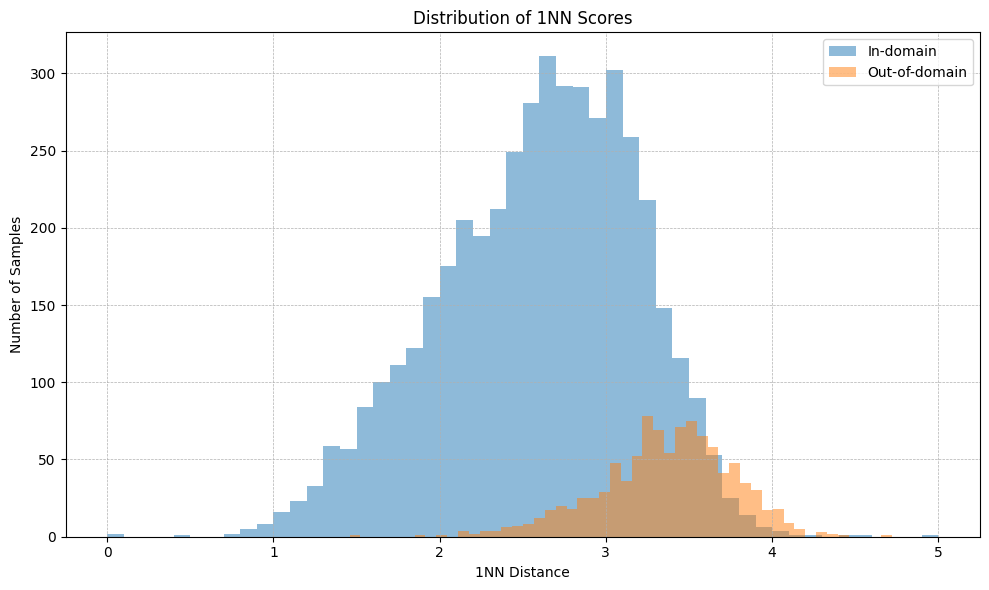

In [292]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(distances_in, bins=50, alpha=0.5, label='In-domain')
plt.hist(distances_out, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of 1NN Scores')
plt.xlabel('1NN Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [293]:
y_true_knn = [0] * len(scores_in) + [1] * len(scores_out)

In [294]:
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_true_knn, y_scores_knn)

In [296]:
aupr_knn = average_precision_score(y_true_knn, y_scores_knn)
aupr_knn


0.5894513743539356

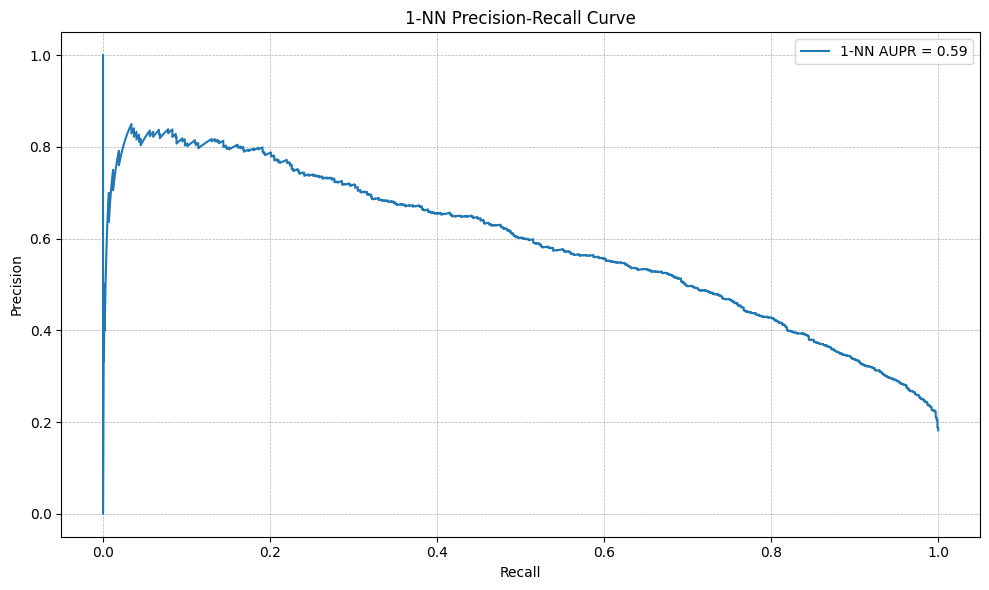

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(recall_knn, precision_knn, label=f'1-NN AUPR = {aupr_knn:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('1-NN Precision-Recall Curve')
plt.legend(loc='upper right') # Changed to 'upper right' to avoid overlap with the curve.
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [109]:
fpr, tpr, thresholds = roc_curve(y_true_knn, y_scores_knn)

# Find the FPR where the TPR is closest to 0.95
idx = np.where(tpr >= 0.95)[0][0]
fpr_95 = fpr[idx]

fpr_95

0.5113333333333333

# K-MEANS

In [110]:
from sklearn.cluster import KMeans

In [143]:
kmeans = KMeans(n_clusters=100, random_state=42).fit(train_embeddings)

/home/ztybigcat/Desktop/my_own_ood/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [144]:
test_distances_to_center = np.min(kmeans.transform(test_embeddings), axis=1)
oos_test_distances_to_center = np.min(kmeans.transform(oos_test_embeddings), axis=1)


In [147]:
y_scores_kmeans = np.concatenate([test_distances_to_center, oos_test_distances_to_center])

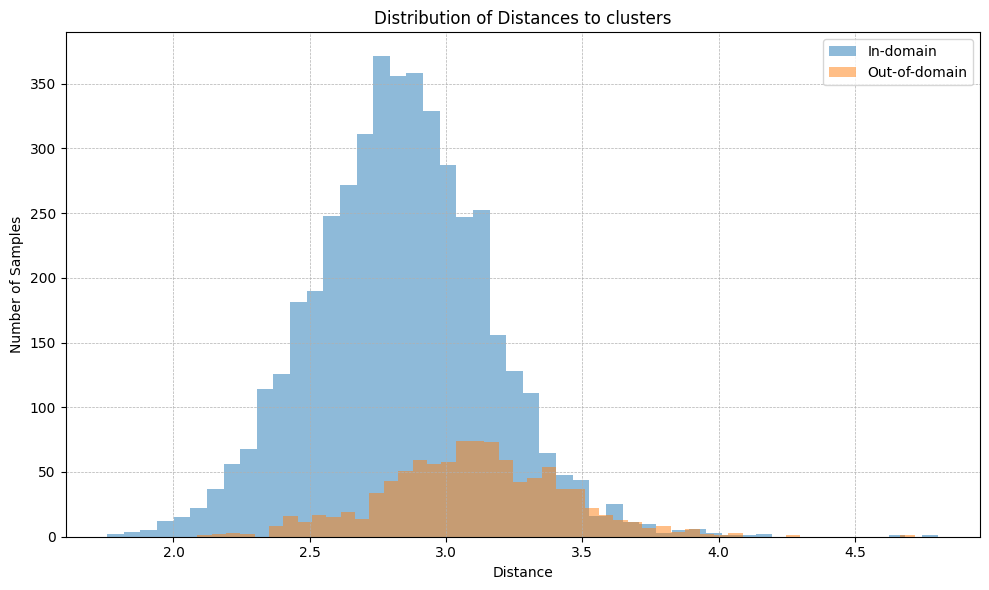

In [145]:
# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_distances_to_center, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_distances_to_center, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Distances to clusters')
plt.xlabel('Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()

In [152]:
precision_kmeans, recall_kmeans, thresholds_kmeans = precision_recall_curve(y_true, y_scores_kmeans)

In [153]:
precision_kmeans, recall_kmeans

(array([0.18181818, 0.18185125, 0.18188432, ..., 0.5       , 0.        ,
        1.        ]),
 array([1.   , 1.   , 1.   , ..., 0.001, 0.   , 0.   ]))

In [154]:
aupr_knn = average_precision_score(y_true, y_scores_kmeans)
aupr_knn

0.3661004389115163

# Fine tunning based on intents

In [303]:
train_sentences[:10]

['what expression would i use to say i love you if i were an italian',
 "can you tell me how to say 'i do not speak much spanish', in spanish",
 "what is the equivalent of, 'life is good' in french",
 "tell me how to say, 'it is a beautiful morning' in italian",
 'if i were mongolian, how would i say that i am a tourist',
 "how do i say 'hotel' in finnish",
 "i need you to translate the sentence, 'we will be there soon' into portuguese",
 'please tell me how to ask for a taxi in french',
 "can you tell me how i would say, 'more bread please' in french",
 "what is the correct way to say 'i am a visitor' in french"]

In [304]:
train_labels[:10]

['translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate',
 'translate']

In [85]:
import torch
from torch import nn
from torch.optim import Adam
from transformers import AutoModel, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [61]:
label_encoder = LabelEncoder()

# Fit the label encoder and transform labels to integers
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_dev_labels = label_encoder.fit_transform(val_labels)

In [68]:
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer

# Your train_sentences and encoded_train_labels
# train_sentences = ["sentence 1", "sentence 2", ...]
# encoded_train_labels = [0, 1, ...]

# 1. Tokenize the sentences
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

class TextDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(sentences, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 2. Create the dataset
max_length = 37  # You can change this to the maximum length that suits your model and data
dataset = TextDataset(train_sentences, encoded_train_labels, tokenizer, max_length)

# 3. Create the data loader
batch_size = 128  # Adjust the batch size according to your needs and GPU memory
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



In [69]:
pretrained_model_name = "distilroberta-base"  # or any other model you wish to use
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
transformer_model = AutoModel.from_pretrained(pretrained_model_name)

# Define a new class for the classification model
class TextClassifier(nn.Module):
    def __init__(self, transformer_model, num_labels):
        super(TextClassifier, self).__init__()
        self.transformer = transformer_model
        # Assuming that we're using a pooled output, you don't necessarily need a separate pooling layer
        # If you do need a specific pooling, you can add it here
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        # Get the output from the transformer model
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # Pool the outputs into a single sentence vector
        # You can use `transformer_output.last_hidden_state.mean(dim=1)` for mean pooling
        # or `transformer_output.last_hidden_state.max(dim=1).values` for max pooling
        sentence_embedding = transformer_output.last_hidden_state.max(dim=1).values
        # Forward pass through the classifier layer
        return self.classifier(sentence_embedding)

In [70]:
num_labels = 150  # Number of labels for your classification task

# Create an instance of the classification model
model = TextClassifier(transformer_model, num_labels)

# Move model to the device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [71]:
num_epochs = 100

In [72]:
for epoch in range(num_epochs):
    model.train()  # put the model in training mode
    total_loss = 0
    for batch in train_dataloader:
        # Unpack the batch
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)

        # Zero the gradients before the forward pass
        optimizer.zero_grad()

        # Forward pass: get predictions
        predictions = model(input_ids, attention_mask)

        # Calculate loss
        loss = loss_function(predictions, labels)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Update model weights
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader)}")

Epoch 1/100, Loss: 2.2401790957329637
Epoch 2/100, Loss: 0.2220599021194345
Epoch 3/100, Loss: 0.08154321944940898
Epoch 4/100, Loss: 0.04956186335470717
Epoch 5/100, Loss: 0.03054190561238487
Epoch 6/100, Loss: 0.02147808101154485
Epoch 7/100, Loss: 0.019431865726739675
Epoch 8/100, Loss: 0.01663228234481382
Epoch 9/100, Loss: 0.01953016818201138
Epoch 10/100, Loss: 0.0271561625768762
Epoch 11/100, Loss: 0.042421074453899164
Epoch 12/100, Loss: 0.025716254973026403
Epoch 13/100, Loss: 0.022148486272179347
Epoch 14/100, Loss: 0.01440447639531882
Epoch 15/100, Loss: 0.014000425162583085
Epoch 16/100, Loss: 0.01653049976300543
Epoch 17/100, Loss: 0.016768137281129167
Epoch 18/100, Loss: 0.009849205570713759
Epoch 19/100, Loss: 0.007083939388394356
Epoch 20/100, Loss: 0.011861465019923714
Epoch 21/100, Loss: 0.013601998307237054
Epoch 22/100, Loss: 0.014226252198321902
Epoch 23/100, Loss: 0.007794592308543496
Epoch 24/100, Loss: 0.008434100038079956
Epoch 25/100, Loss: 0.01093055637182383

In [82]:
# After training, save the model and the classifier
fine_tuned_transformer_model = model.transformer
model_path = 'sentence_transformer_model'
# Save the fine-tuned transformer model
fine_tuned_transformer_model.save_pretrained(model_path)
tokenizer_path = 'tokenizer'
tokenizer.save_pretrained(tokenizer_path)

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [81]:
def encode_sentences(sentences, model_path, tokenizer_path):
    # Load tokenizer and model from their respective directories
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    model = AutoModel.from_pretrained(model_path)
    model.eval()  # Put the model in evaluation mode

    # Initialize an empty list to store our embeddings
    sentence_embeddings = []

    # Process each sentence
    for sentence in sentences:
        # Tokenize the sentence and convert to tensor
        encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)

        # Compute token embeddings
        with torch.no_grad():
            model_output = model(**encoded_input)

        # Perform pooling to get one vector per sentence (mean pooling here)
        # You can change to max pooling or CLS token embedding based on your preference
        pooled_output = model_output.last_hidden_state.mean(dim=1)

        # Move to CPU and convert to numpy if on GPU
        sentence_embeddings.append(pooled_output.cpu().numpy())

    # Convert list of arrays to a single 2D array
    sentence_embeddings_np = np.concatenate(sentence_embeddings, axis=0)
    return sentence_embeddings_np

In [90]:
oos_val_embeddings_fine = encode_sentences(oos_val_sentences, model_path, tokenizer_path)

In [93]:
oos_val_embeddings_fine.shape

(100, 768)

In [92]:
oos_val_embeddings.shape

(100, 768)

In [94]:
oos_val_embeddings == oos_val_embeddings_fine

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [426]:
torch.cuda.empty_cache()